In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# Data Wrangling

In [2]:
data = pd.read_csv(r"C:\Users\ryanp\Desktop\Springboard\Springboard\E-commerce data\data.csv", encoding= 'unicode_escape')
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [3]:
data.shape

(541909, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**The data contains 541,909 columns and 8 rows. We can also see the different types of data contained within the columns.**

In [5]:
missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
missing.columns = ['count', '%']
missing.sort_values(by='count')

count          %
InvoiceNo         0   0.000000
StockCode         0   0.000000
Quantity          0   0.000000
InvoiceDate       0   0.000000
UnitPrice         0   0.000000
Country           0   0.000000
Description    1454   0.268311
CustomerID   135080  24.926694

In [6]:
data = data.dropna()
data.shape

(406829, 8)

**There is about 25% total data that is missing, with the majority of missing data within the Customer ID column. Without the Customer ID, it is difficult to fill that value with any other data and to avoid data manipulation, all rows with missing data will be dropped. The new data shape can be seen.** 

In [7]:
data.describe()

Quantity      UnitPrice     CustomerID
count  406829.000000  406829.000000  406829.000000
mean       12.061303       3.460471   15287.690570
std       248.693370      69.315162    1713.600303
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13953.000000
50%         5.000000       1.950000   15152.000000
75%        12.000000       3.750000   16791.000000
max     80995.000000   38970.000000   18287.000000

**The data contains outliers as you can seen within the Quantity column containing negative values. Further outliers will be investigated.**

In [8]:
data[data['InvoiceNo'] == 0].count()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
data[data['Quantity'] < 0].count()

InvoiceNo      8905
StockCode      8905
Description    8905
Quantity       8905
InvoiceDate    8905
UnitPrice      8905
CustomerID     8905
Country        8905
dtype: int64

In [10]:
data = data[data['Quantity'] >= 0]
data.shape

(397924, 8)

In [11]:
data[data['UnitPrice'] < 0].count()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
data[data['UnitPrice'] == 0].count()

InvoiceNo      40
StockCode      40
Description    40
Quantity       40
InvoiceDate    40
UnitPrice      40
CustomerID     40
Country        40
dtype: int64

In [13]:
data = data[data['UnitPrice'] > 0]
data.shape

(397884, 8)

In [14]:
data.duplicated().sum()

5192

In [15]:
data.drop_duplicates(inplace=True)
data.shape

(392692, 8)

**There were more outliers identified within the Unit Price column and duplicated rows were identified. All these rows will be dropped.**

In [16]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].head(1)

0   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

**The Invoice Date was changed to represent its true value as a date.**

In [17]:
data['Revenue'] = data["Quantity"] * data["UnitPrice"]

In [18]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Revenue  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34

**A new column called Total Cost was added to the DataFrame. This data contains the unit price mulitplied by quantity to find how much each order costed for each customer.**

In [19]:
data = data[['CustomerID','InvoiceNo', 'InvoiceDate', 'Country', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'Revenue']]

In [20]:
data.head()

CustomerID InvoiceNo         InvoiceDate         Country StockCode  \
0     17850.0    536365 2010-12-01 08:26:00  United Kingdom    85123A   
1     17850.0    536365 2010-12-01 08:26:00  United Kingdom     71053   
2     17850.0    536365 2010-12-01 08:26:00  United Kingdom    84406B   
3     17850.0    536365 2010-12-01 08:26:00  United Kingdom    84029G   
4     17850.0    536365 2010-12-01 08:26:00  United Kingdom    84029E   

                           Description  Quantity  UnitPrice  Revenue  
0   WHITE HANGING HEART T-LIGHT HOLDER         6       2.55    15.30  
1                  WHITE METAL LANTERN         6       3.39    20.34  
2       CREAM CUPID HEARTS COAT HANGER         8       2.75    22.00  
3  KNITTED UNION FLAG HOT WATER BOTTLE         6       3.39    20.34  
4       RED WOOLLY HOTTIE WHITE HEART.         6       3.39    20.34

**The DataFrame was organized to be read easier.**

In [21]:
data['CustomerID'] = data['CustomerID'].astype(int)
data['CustomerID'].head(1)

0    17850
Name: CustomerID, dtype: int32

**The Customer ID was changed to an integer type to make the data more cleaner.**

In [22]:
data.describe()

CustomerID       Quantity      UnitPrice        Revenue
count  392692.000000  392692.000000  392692.000000  392692.000000
mean    15287.843865      13.119702       3.125914      22.631500
std      1713.539549     180.492832      22.241836     311.099224
min     12346.000000       1.000000       0.001000       0.001000
25%     13955.000000       2.000000       1.250000       4.950000
50%     15150.000000       6.000000       1.950000      12.450000
75%     16791.000000      12.000000       3.750000      19.800000
max     18287.000000   80995.000000    8142.750000  168469.600000

**The numerical data has much improved and appears to be ready to be explored and analyzed.**

## EDA

### Company Overview

In [23]:
%%html
<div class='tableauPlaceholder' id='viz1620855012158' style='position: relative'><noscript><a href='#'><img alt='Quarterly Orders and Revenue ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;QuarterlyOrdersandRevenue&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneProject_16206216437160&#47;QuarterlyOrdersandRevenue' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;QuarterlyOrdersandRevenue&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1620855012158');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

#### Country

In [24]:
%%html
<div class='tableauPlaceholder' id='viz1620854654927' style='position: relative'><noscript><a href='#'><img alt='Map ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;Map&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneProject_16206216437160&#47;Map' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;Map&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1620854654927');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [25]:
%%html 
<div class='tableauPlaceholder' id='viz1620854881154' style='position: relative'><noscript><a href='#'><img alt='Customer per Country ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;CustomerperCountry&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneProject_16206216437160&#47;CustomerperCountry' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;CustomerperCountry&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1620854881154');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [26]:
%%html
<div class='tableauPlaceholder' id='viz1620854899871' style='position: relative'><noscript><a href='#'><img alt='Customer per Country (without UK) ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;CustomerperCountrywithoutUK&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneProject_16206216437160&#47;CustomerperCountrywithoutUK' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;CustomerperCountrywithoutUK&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1620854899871');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [27]:
country_count = data.Country.value_counts().sort_values(ascending=False).head(20)
fig = px.scatter(country_count, x=country_count.index, y=country_count.values, size=country_count.values, size_max=100)
fig.update_layout(
    yaxis_title="# of Orders per Country",
    xaxis_title="Country")
fig.show()

**A large majority of the orders were placed from the United Kingdom. This bar graph shows the the top 20 countries out of the total 37 countries the orders were placed in. Any of other countries were not nearly close to the UK.**

In [28]:
revenue_per_country = data.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
df = px.data.gapminder()

fig = px.scatter(revenue_per_country, x=revenue_per_country.index, y=revenue_per_country.values, 
                 size=revenue_per_country.values, size_max=100)
fig.update_layout(
    xaxis_title="Country",
    yaxis_title="Total Revenue per Country")
fig.show()

In [29]:
%%html
<div class='tableauPlaceholder' id='viz1620855524892' style='position: relative'><noscript><a href='#'><img alt='Revenue per Country (without UK) ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;RevenueperCountrywithoutUK&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneProject_16206216437160&#47;RevenueperCountrywithoutUK' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;RevenueperCountrywithoutUK&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1620855524892');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [30]:
data_UK = data[data['Country'] == 'United Kingdom']
data_UK.head(1)
print(data_UK.shape)
print(data.shape)

(349203, 9)
(392692, 9)


In [31]:
data_no_UK = data[data['Country'] != 'United Kingdom']
data_no_UK.shape

(43489, 9)

### Customer

In [32]:
%%html
<div class='tableauPlaceholder' id='viz1620855097925' style='position: relative'><noscript><a href='#'><img alt='Revenue per Customer ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;RevenueperCustomer&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneProject_16206216437160&#47;RevenueperCustomer' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;RevenueperCustomer&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1620855097925');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Text(0.5, 0, 'Customer ID')

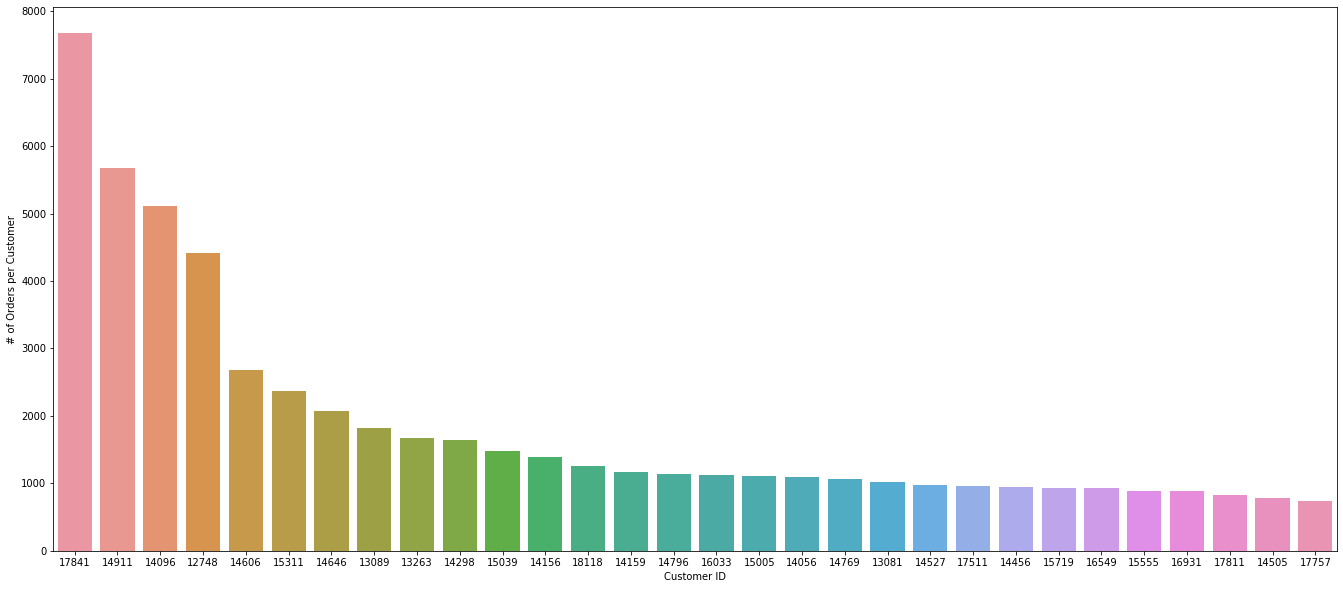

In [33]:
customer_count = data.CustomerID.value_counts().head(30)
customer_count_ordered = customer_count.sort_values(ascending=True)
plt.figure(figsize=(23, 10))
sns.barplot(x=customer_count_ordered.index, y=customer_count_ordered.values, order=customer_count.index)
plt.ylabel('# of Orders per Customer')
plt.xlabel('Customer ID')

In [34]:
%%html
<div class='tableauPlaceholder' id='viz1620855503218' style='position: relative'><noscript><a href='#'><img alt='Invoice per Customer ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;InvoiceperCustomer&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneProject_16206216437160&#47;InvoiceperCustomer' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneProject_16206216437160&#47;InvoiceperCustomer&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1620855503218');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Product

In [35]:
product_count = data.StockCode.value_counts().sort_values(ascending=False).head(30)
plt.figure(figsize=(20, 10))
sns.barplot(product_count.index, product_count.values)
plt.ylabel('# of Counts per Product')
plt.xlabel('Customer ID')

Text(0.5, 0, 'Customer ID')

Text(0.5, 0, 'product')

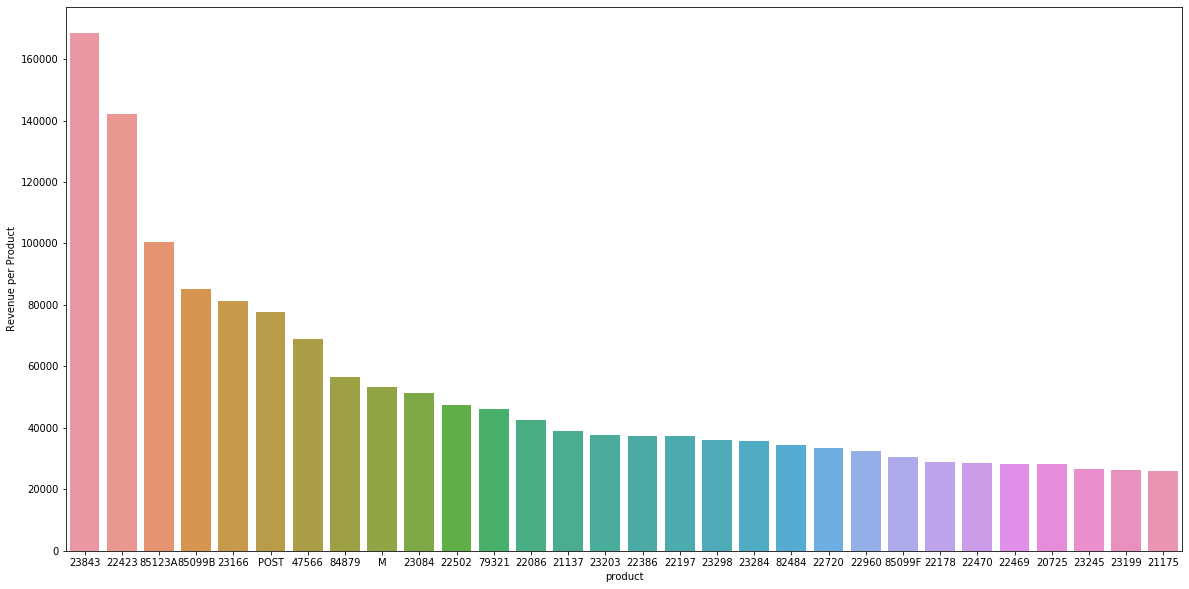

In [36]:
revenue_per_product = data.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False).head(30)
plt.figure(figsize=(20, 10))
sns.barplot(revenue_per_product.index, revenue_per_product.values)
plt.ylabel('Revenue per Product')
plt.xlabel('product')

In [37]:
revenue_per_product.head(10)

StockCode
23843     168469.60
22423     142264.75
85123A    100547.45
85099B     85040.54
23166      81416.73
POST       77803.96
47566      68785.23
84879      56413.03
M          53419.93
23084      51251.24
Name: Revenue, dtype: float64

In [38]:
uniqueValues = data[data['StockCode'].str.contains('^[a-zA-Z]', regex=True)]['StockCode'].unique()
uniqueValues

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [39]:
data = data[~data['StockCode'].isin(['BANK CHARGES', 'C2', 'DOT', 'M', 'PADS', 'POST'])]

Text(0.5, 0, 'product')

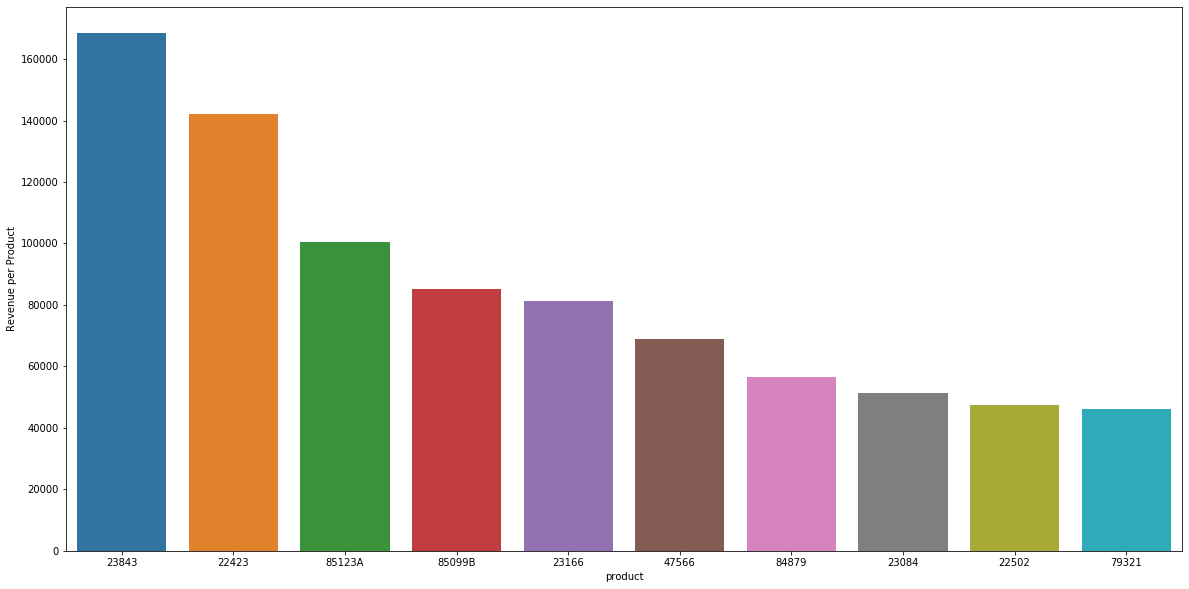

In [40]:
revenue_per_product = data.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(20, 10))
sns.barplot(revenue_per_product.index, revenue_per_product.values)
plt.ylabel('Revenue per Product')
plt.xlabel('product')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

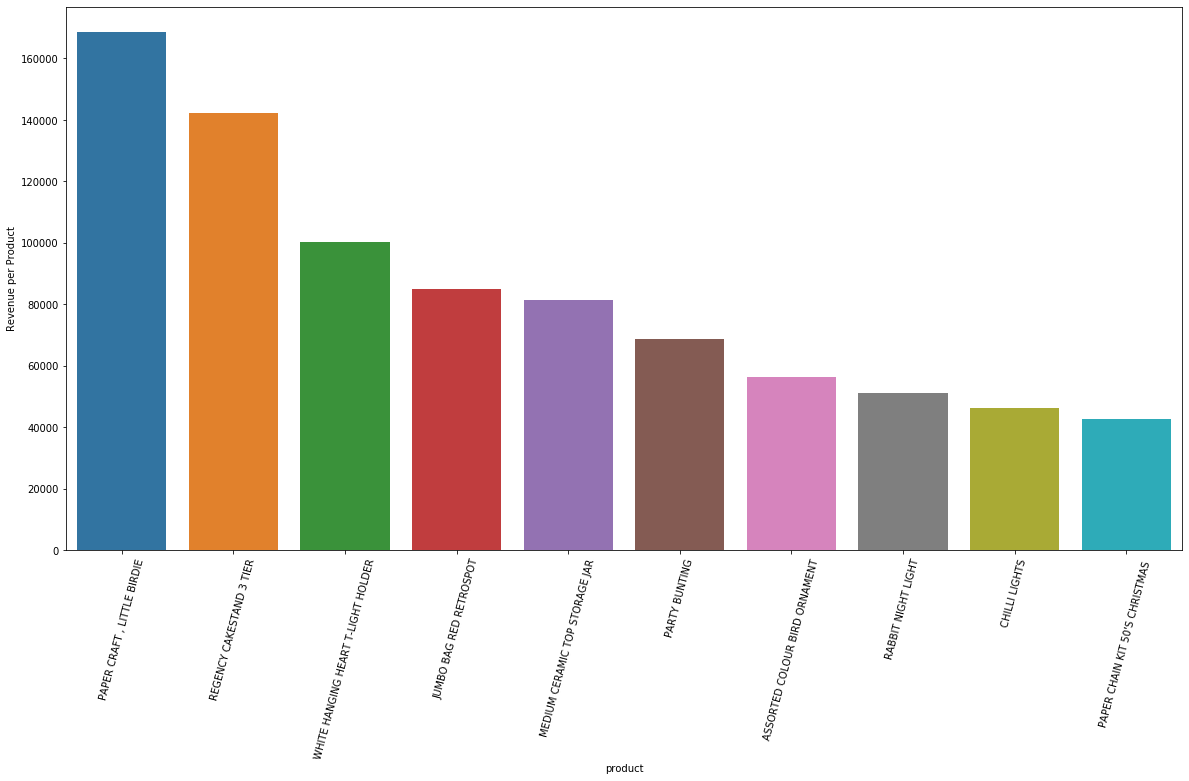

In [41]:
Product_description = data.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(20, 10))
sns.barplot(Product_description.index, Product_description.values)
plt.ylabel('Revenue per Product')
plt.xlabel('product')
plt.xticks(rotation=75)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

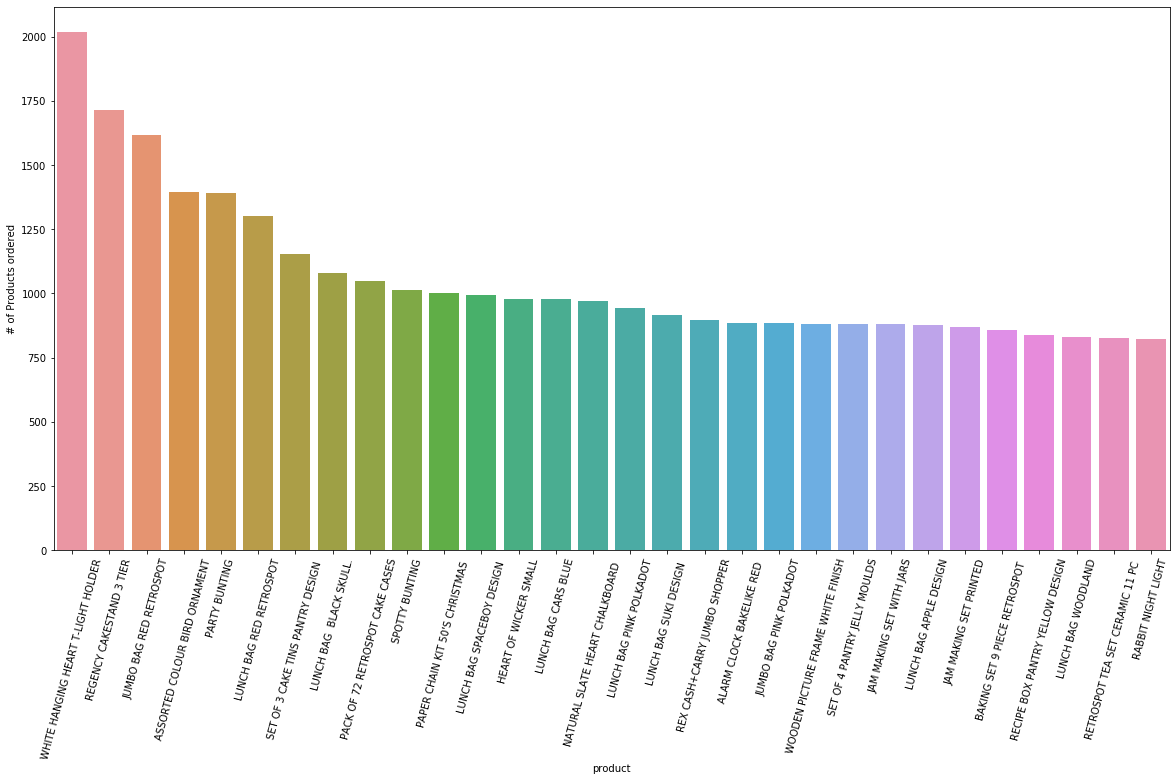

In [42]:
num_of_descriptions = data.Description.value_counts().sort_values(ascending=False).head(30)
plt.figure(figsize=(20, 10))
sns.barplot(num_of_descriptions.index, num_of_descriptions.values)
plt.ylabel('# of Products ordered')
plt.xlabel('product')
plt.xticks(rotation=75)

## Customer Segmentation

### Recent Purchase 

In [43]:
from datetime import datetime

today = datetime.date(data['InvoiceDate'].max())
print(today)

2011-12-09


In [44]:
data['Date'] = pd.to_datetime(data['InvoiceDate']).dt.date
data['Date']

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: Date, Length: 391150, dtype: object

In [45]:
recent_purchase_no_UK = data_no_UK.groupby('CustomerID', as_index=False)['InvoiceDate'].max()
recent_purchase_no_UK['InvoiceDate'] = pd.DatetimeIndex(recent_purchase_no_UK['InvoiceDate']).date
recent_purchase_no_UK['Recency'] = today - recent_purchase_no_UK['InvoiceDate']
recent_purchase_no_UK.columns = ['CustomerID', 'InvoiceDate', 'Recency']
recent_purchase_no_UK

CustomerID InvoiceDate  Recency
0         12347  2011-12-07   2 days
1         12348  2011-09-25  75 days
2         12349  2011-11-21  18 days
3         12350  2011-02-02 310 days
4         12352  2011-11-03  36 days
..          ...         ...      ...
413       17444  2011-07-15 147 days
414       17508  2011-03-04 280 days
415       17828  2011-11-17  22 days
416       17829  2011-02-14 298 days
417       17844  2011-08-25 106 days

[418 rows x 3 columns]

In [46]:
recent_purchase_no_UK = recent_purchase_no_UK.drop(['InvoiceDate'], axis=1)
recent_purchase_no_UK

CustomerID  Recency
0         12347   2 days
1         12348  75 days
2         12349  18 days
3         12350 310 days
4         12352  36 days
..          ...      ...
413       17444 147 days
414       17508 280 days
415       17828  22 days
416       17829 298 days
417       17844 106 days

[418 rows x 2 columns]

In [47]:
recent_purchase_UK = data_UK.groupby('CustomerID', as_index=False)['InvoiceDate'].max()
recent_purchase_UK['InvoiceDate'] = pd.DatetimeIndex(recent_purchase_UK['InvoiceDate']).date
recent_purchase_UK['Recency'] = today - recent_purchase_UK['InvoiceDate']
recent_purchase_UK.columns = ['CustomerID', 'InvoiceDate', 'Recency']
recent_purchase_UK

CustomerID InvoiceDate  Recency
0          12346  2011-01-18 325 days
1          12747  2011-12-07   2 days
2          12748  2011-12-09   0 days
3          12749  2011-12-06   3 days
4          12820  2011-12-06   3 days
...          ...         ...      ...
3915       18280  2011-03-07 277 days
3916       18281  2011-06-12 180 days
3917       18282  2011-12-02   7 days
3918       18283  2011-12-06   3 days
3919       18287  2011-10-28  42 days

[3920 rows x 3 columns]

In [48]:
recent_purchase_UK = recent_purchase_UK.drop(['InvoiceDate'], axis=1)
recent_purchase_UK

CustomerID  Recency
0          12346 325 days
1          12747   2 days
2          12748   0 days
3          12749   3 days
4          12820   3 days
...          ...      ...
3915       18280 277 days
3916       18281 180 days
3917       18282   7 days
3918       18283   3 days
3919       18287  42 days

[3920 rows x 2 columns]

### Frequency

In [49]:
purchase_count_no_UK = data_no_UK.groupby('CustomerID', as_index=False)['InvoiceNo'].count()
purchase_count_no_UK.columns = ['CustomerID', 'Purchase_Count']
purchase_count_no_UK

CustomerID  Purchase_Count
0         12347             182
1         12348              31
2         12349              73
3         12350              17
4         12352              85
..          ...             ...
413       17444             135
414       17508              22
415       17828              67
416       17829              30
417       17844               5

[418 rows x 2 columns]

In [50]:
purchase_count_UK = data_UK.groupby('CustomerID', as_index=False)['InvoiceNo'].count()
purchase_count_UK.columns = ['CustomerID', 'Purchase_Count']
purchase_count_UK

CustomerID  Purchase_Count
0          12346               1
1          12747             103
2          12748            4412
3          12749             199
4          12820              59
...          ...             ...
3915       18280              10
3916       18281               7
3917       18282              12
3918       18283             721
3919       18287              70

[3920 rows x 2 columns]

### Customer Spending 

In [51]:
spending_no_UK = data_no_UK.groupby('CustomerID', as_index=False)['Revenue'].sum()
spending_no_UK.columns = ['CustomerID', 'Spending']
spending_no_UK

CustomerID  Spending
0         12347   4310.00
1         12348   1797.24
2         12349   1757.55
3         12350    334.40
4         12352   2506.04
..          ...       ...
413       17444   2940.04
414       17508    387.31
415       17828   1820.09
416       17829    889.24
417       17844     51.56

[418 rows x 2 columns]

In [52]:
spending_UK = data_UK.groupby('CustomerID', as_index=False)['Revenue'].sum()
spending_UK.columns = ['CustomerID', 'Spending']
spending_UK

CustomerID  Spending
0          12346  77183.60
1          12747   4196.01
2          12748  33053.19
3          12749   4090.88
4          12820    942.34
...          ...       ...
3915       18280    180.60
3916       18281     80.82
3917       18282    178.05
3918       18283   2045.53
3919       18287   1837.28

[3920 rows x 2 columns]

#### Merging the Data

In [53]:
test_data_no_UK = pd.merge(recent_purchase_no_UK, purchase_count_no_UK, on = 'CustomerID')
test_data_no_UK = pd.merge(test_data_no_UK, spending_no_UK, on = 'CustomerID')
test_data_no_UK

CustomerID  Recency  Purchase_Count  Spending
0         12347   2 days             182   4310.00
1         12348  75 days              31   1797.24
2         12349  18 days              73   1757.55
3         12350 310 days              17    334.40
4         12352  36 days              85   2506.04
..          ...      ...             ...       ...
413       17444 147 days             135   2940.04
414       17508 280 days              22    387.31
415       17828  22 days              67   1820.09
416       17829 298 days              30    889.24
417       17844 106 days               5     51.56

[418 rows x 4 columns]

In [54]:
test_data_UK = pd.merge(recent_purchase_UK, purchase_count_UK, on = 'CustomerID')
test_data_UK = pd.merge(test_data_UK, spending_UK, on = 'CustomerID')
test_data_UK

CustomerID  Recency  Purchase_Count  Spending
0          12346 325 days               1  77183.60
1          12747   2 days             103   4196.01
2          12748   0 days            4412  33053.19
3          12749   3 days             199   4090.88
4          12820   3 days              59    942.34
...          ...      ...             ...       ...
3915       18280 277 days              10    180.60
3916       18281 180 days               7     80.82
3917       18282   7 days              12    178.05
3918       18283   3 days             721   2045.53
3919       18287  42 days              70   1837.28

[3920 rows x 4 columns]

In [55]:
quartiles_no_UK = test_data_no_UK.quantile(q=[0.25, 0.5, 0.75])
quartiles_no_UK

CustomerID  Purchase_Count   Spending
0.25    12476.25            22.0   457.9750
0.50    12605.50            45.0  1031.9950
0.75    12730.50           102.5  2705.6375

In [56]:
quartiles_UK = test_data_UK.quantile(q=[0.25, 0.5, 0.75])
quartiles_UK

CustomerID  Purchase_Count  Spending
0.25    14208.75            17.0   298.185
0.50    15569.50            40.0   644.975
0.75    16913.25            98.0  1571.285

In [57]:
recency_quartiles = range(3, 0, -1)
purchase_count_quartiles = range(1, 4)
spending_quartiles = range(1, 4)

In [58]:
recency_group_no_UK = pd.qcut(test_data_no_UK['Recency'], q=3, labels=recency_quartiles)
puchase_count_group_no_UK = pd.qcut(test_data_no_UK['Purchase_Count'], q=3, labels=purchase_count_quartiles)
spending_group_no_UK = pd.qcut(test_data_no_UK['Spending'], q=3, labels=spending_quartiles)

In [59]:
recency_group_UK = pd.qcut(test_data_UK['Recency'], q=3, labels=recency_quartiles)
puchase_count_group_UK = pd.qcut(test_data_UK['Purchase_Count'], q=3, labels=purchase_count_quartiles)
spending_group_UK = pd.qcut(test_data_UK['Spending'], q=3, labels=spending_quartiles)

In [60]:
test_data_no_UK['R'] = recency_group_no_UK.values
test_data_no_UK['F'] = puchase_count_group_no_UK.values
test_data_no_UK['M'] = spending_group_no_UK.values
test_data_no_UK['RFM_Score'] = test_data_no_UK[['R', 'F', 'M']].sum(axis=1)
test_data_no_UK

CustomerID  Recency  Purchase_Count  Spending  R  F  M  RFM_Score
0         12347   2 days             182   4310.00  3  3  3          9
1         12348  75 days              31   1797.24  2  2  2          6
2         12349  18 days              73   1757.55  3  2  2          7
3         12350 310 days              17    334.40  1  1  1          3
4         12352  36 days              85   2506.04  2  3  3          8
..          ...      ...             ...       ... .. .. ..        ...
413       17444 147 days             135   2940.04  1  3  3          7
414       17508 280 days              22    387.31  1  1  1          3
415       17828  22 days              67   1820.09  3  2  2          7
416       17829 298 days              30    889.24  1  2  2          5
417       17844 106 days               5     51.56  1  1  1          3

[418 rows x 8 columns]

In [61]:
test_data_UK['R'] = recency_group_UK.values
test_data_UK['F'] = puchase_count_group_UK.values
test_data_UK['M'] = spending_group_UK.values
test_data_UK['RFM_Score'] = test_data_UK[['R', 'F', 'M']].sum(axis=1)
test_data_UK

CustomerID  Recency  Purchase_Count  Spending  R  F  M  RFM_Score
0          12346 325 days               1  77183.60  1  1  3          5
1          12747   2 days             103   4196.01  3  3  3          9
2          12748   0 days            4412  33053.19  3  3  3          9
3          12749   3 days             199   4090.88  3  3  3          9
4          12820   3 days              59    942.34  3  2  2          7
...          ...      ...             ...       ... .. .. ..        ...
3915       18280 277 days              10    180.60  1  1  1          3
3916       18281 180 days               7     80.82  1  1  1          3
3917       18282   7 days              12    178.05  3  1  1          5
3918       18283   3 days             721   2045.53  3  3  3          9
3919       18287  42 days              70   1837.28  2  2  3          7

[3920 rows x 8 columns]

In [62]:
test_data_no_UK['RFM_Score'].unique()

array([9, 6, 7, 3, 8, 5, 4], dtype=int64)

In [63]:
test_data_UK['RFM_Score'].unique()

array([5, 9, 7, 3, 6, 8, 4], dtype=int64)

In [64]:
def Customer_levels(test_data_no_UK):
    if test_data_no_UK['RFM_Score'] == 9:
        return "Elite"
    elif test_data_no_UK['RFM_Score'] >= 7:
        return "High"
    elif test_data_no_UK['RFM_Score'] >= 5:
        return "Medium"
    else:
        return "Low"

In [65]:
test_data_no_UK['Customer_Score'] = test_data_no_UK.apply(Customer_levels, axis=1)
test_data_no_UK

CustomerID  Recency  Purchase_Count  Spending  R  F  M  RFM_Score  \
0         12347   2 days             182   4310.00  3  3  3          9   
1         12348  75 days              31   1797.24  2  2  2          6   
2         12349  18 days              73   1757.55  3  2  2          7   
3         12350 310 days              17    334.40  1  1  1          3   
4         12352  36 days              85   2506.04  2  3  3          8   
..          ...      ...             ...       ... .. .. ..        ...   
413       17444 147 days             135   2940.04  1  3  3          7   
414       17508 280 days              22    387.31  1  1  1          3   
415       17828  22 days              67   1820.09  3  2  2          7   
416       17829 298 days              30    889.24  1  2  2          5   
417       17844 106 days               5     51.56  1  1  1          3   

    Customer_Score  
0            Elite  
1           Medium  
2             High  
3              Low  
4             High  
..             ...  
413           High  
414            Low  
415           High  
416         Medium  
417            Low  

[418 rows x 9 columns]

In [66]:
def Customer_levels2(test_data_UK):
    if test_data_UK['RFM_Score'] == 9:
        return "Elite"
    elif test_data_UK['RFM_Score'] >= 7:
        return "High"
    elif test_data_UK['RFM_Score'] >= 5:
        return "Medium"
    else:
        return "Low"

In [67]:
test_data_UK['Customer_Score'] = test_data_UK.apply(Customer_levels2, axis=1)
test_data_UK

CustomerID  Recency  Purchase_Count  Spending  R  F  M  RFM_Score  \
0          12346 325 days               1  77183.60  1  1  3          5   
1          12747   2 days             103   4196.01  3  3  3          9   
2          12748   0 days            4412  33053.19  3  3  3          9   
3          12749   3 days             199   4090.88  3  3  3          9   
4          12820   3 days              59    942.34  3  2  2          7   
...          ...      ...             ...       ... .. .. ..        ...   
3915       18280 277 days              10    180.60  1  1  1          3   
3916       18281 180 days               7     80.82  1  1  1          3   
3917       18282   7 days              12    178.05  3  1  1          5   
3918       18283   3 days             721   2045.53  3  3  3          9   
3919       18287  42 days              70   1837.28  2  2  3          7   

     Customer_Score  
0            Medium  
1             Elite  
2             Elite  
3             Elite  
4              High  
...             ...  
3915            Low  
3916            Low  
3917         Medium  
3918          Elite  
3919           High  

[3920 rows x 9 columns]

In [68]:
test_data_UK['Recency'] = test_data_UK['Recency'].dt.days
test_data_no_UK['Recency'] = test_data_no_UK['Recency'].dt.days

In [69]:
test_data_UK['R'] = test_data_UK['R'].astype(int)
test_data_UK['F'] = test_data_UK['F'].astype(int)
test_data_UK['M'] = test_data_UK['M'].astype(int)
test_data_UK.dtypes

CustomerID          int64
Recency             int64
Purchase_Count      int64
Spending          float64
R                   int32
F                   int32
M                   int32
RFM_Score           int64
Customer_Score     object
dtype: object

In [70]:
test_data_no_UK['R'] = test_data_no_UK['R'].astype(int)
test_data_no_UK['F'] = test_data_no_UK['F'].astype(int)
test_data_no_UK['M'] = test_data_no_UK['M'].astype(int)
test_data_no_UK.dtypes

CustomerID          int64
Recency             int64
Purchase_Count      int64
Spending          float64
R                   int32
F                   int32
M                   int32
RFM_Score           int64
Customer_Score     object
dtype: object

## Pre-Processing

In [71]:
test_data_no_UK.describe()

CustomerID     Recency  Purchase_Count       Spending           R  \
count    418.000000  418.000000       418.00000     418.000000  418.000000   
mean   12846.641148   95.035885       104.04067    3832.976675    2.009569   
std      891.170868  104.472438       313.31056   17621.307220    0.822294   
min    12347.000000    0.000000         1.00000      51.560000    1.000000   
25%    12476.250000   18.250000        22.00000     457.975000    1.000000   
50%    12605.500000   52.000000        45.00000    1031.995000    2.000000   
75%    12730.500000  135.500000       102.50000    2705.637500    3.000000   
max    17844.000000  373.000000      5670.00000  280206.020000    3.000000   

                F           M   RFM_Score  
count  418.000000  418.000000  418.000000  
mean     1.988038    1.997608    5.995215  
std      0.817876    0.817960    2.070688  
min      1.000000    1.000000    3.000000  
25%      1.000000    1.000000    4.000000  
50%      2.000000    2.000000    6.000000  
75%      3.000000    3.000000    8.000000  
max      3.000000    3.000000    9.000000

In [72]:
test_data_UK.describe()

CustomerID      Recency  Purchase_Count       Spending            R  \
count   3920.000000  3920.000000     3920.000000    3920.000000  3920.000000   
mean   15562.059694    91.742092       89.082398    1858.424654     2.009439   
std     1576.594671    99.533485      214.034542    7478.631256     0.822410   
min    12346.000000     0.000000        1.000000       3.750000     1.000000   
25%    14208.750000    17.000000       17.000000     298.185000     1.000000   
50%    15569.500000    50.000000       40.000000     644.975000     2.000000   
75%    16913.250000   142.000000       98.000000    1571.285000     3.000000   
max    18287.000000   373.000000     7676.000000  259657.300000     3.000000   

                 F            M    RFM_Score  
count  3920.000000  3920.000000  3920.000000  
mean      1.992857     2.000000     6.002296  
std       0.820414     0.816705     2.027055  
min       1.000000     1.000000     3.000000  
25%       1.000000     1.000000     4.000000  
50%       2.000000     2.000000     6.000000  
75%       3.000000     3.000000     8.000000  
max       3.000000     3.000000     9.000000

In [73]:
df = px.data.tips()
fig = px.histogram(test_data_no_UK, x="Customer_Score", color='Customer_Score')
fig.show()

In [74]:
df = px.data.tips()
fig = px.histogram(test_data_UK, x="Customer_Score", color='Customer_Score')
fig.show()

In [75]:
df = px.data.tips()
fig = px.histogram(test_data_no_UK, x="Recency")
fig.show()

In [76]:
recency_no_UK_log = np.log(test_data_no_UK['Recency'])
df = px.data.tips()
fig = px.histogram(recency_no_UK_log)
fig.show()

C:\Users\ryanp\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

divide by zero encountered in log



In [77]:
df = px.data.tips()
fig = px.histogram(test_data_UK, x="Recency")
fig.show()

In [78]:
recency_UK_log = np.log(test_data_UK['Recency'])
df = px.data.tips()
fig = px.histogram(recency_UK_log)
fig.show()

In [79]:
df = px.data.tips()
fig = px.histogram(test_data_no_UK, x="Purchase_Count")
fig.show()

In [80]:
purchase_no_UK_log = np.log(test_data_no_UK['Purchase_Count'])
df = px.data.tips()
fig = px.histogram(purchase_no_UK_log)
fig.show()

In [81]:
df = px.data.tips()
fig = px.histogram(test_data_UK, x="Purchase_Count")
fig.show()

In [82]:
purchase_UK_log = np.log(test_data_UK['Purchase_Count'])
df = px.data.tips()
fig = px.histogram(purchase_no_UK_log)
fig.show()

In [83]:
df = px.data.tips()
fig = px.histogram(test_data_no_UK, x="Spending")
fig.show()

In [84]:
spending_no_UK_log = np.log(test_data_no_UK['Spending'])
df = px.data.tips()
fig = px.histogram(spending_no_UK_log)
fig.show()

In [85]:
df = px.data.tips()
fig = px.histogram(test_data_UK, x="Spending")
fig.show()

In [86]:
spending_UK_log = np.log(test_data_UK['Spending'])
df = px.data.tips()
fig = px.histogram(spending_UK_log)
fig.show()

In [87]:
score_no_UK_log = np.log(test_data_no_UK['RFM_Score'])
df = px.data.tips()
fig = px.histogram(score_no_UK_log)
fig.show()

In [88]:
score_UK_log = np.log(test_data_UK['RFM_Score'])
df = px.data.tips()
fig = px.histogram(score_UK_log)
fig.show()

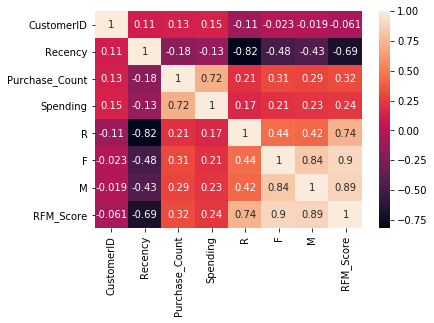

In [89]:
sns.heatmap(test_data_no_UK.corr(), annot=True)

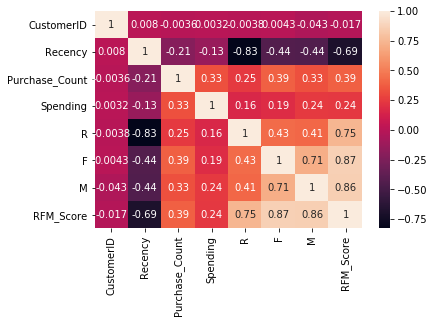

In [90]:
sns.heatmap(test_data_UK.corr(), annot=True)

## Scaling

In [91]:
from sklearn.preprocessing import StandardScaler

In [92]:
scaler = StandardScaler()

### No UK Data

In [93]:
test_data_no_UK = test_data_no_UK.drop(['Customer_Score', 'CustomerID'], axis=1)
print(test_data_no_UK)

     Recency  Purchase_Count  Spending  R  F  M  RFM_Score
0          2             182   4310.00  3  3  3          9
1         75              31   1797.24  2  2  2          6
2         18              73   1757.55  3  2  2          7
3        310              17    334.40  1  1  1          3
4         36              85   2506.04  2  3  3          8
..       ...             ...       ... .. .. ..        ...
413      147             135   2940.04  1  3  3          7
414      280              22    387.31  1  1  1          3
415       22              67   1820.09  3  2  2          7
416      298              30    889.24  1  2  2          5
417      106               5     51.56  1  1  1          3

[418 rows x 7 columns]


In [94]:
test_data_no_UK += 1

In [95]:
test_data_no_UK_log = np.log(test_data_no_UK)
print(test_data_no_UK_log)

      Recency  Purchase_Count  Spending         R         F         M  \
0    1.098612        5.209486  8.368925  1.386294  1.386294  1.386294   
1    4.330733        3.465736  7.494564  1.098612  1.098612  1.098612   
2    2.944439        4.304065  7.472245  1.386294  1.098612  1.098612   
3    5.739793        2.890372  5.815324  0.693147  0.693147  0.693147   
4    3.610918        4.454347  7.826858  1.098612  1.386294  1.386294   
..        ...             ...       ...       ...       ...       ...   
413  4.997212        4.912655  7.986519  0.693147  1.386294  1.386294   
414  5.638355        3.135494  5.961804  0.693147  0.693147  0.693147   
415  3.135494        4.219508  7.507191  1.386294  1.098612  1.098612   
416  5.700444        3.433987  6.791491  0.693147  1.098612  1.098612   
417  4.672829        1.791759  3.961955  0.693147  0.693147  0.693147   

     RFM_Score  
0     2.302585  
1     1.945910  
2     2.079442  
3     1.386294  
4     2.197225  
..         ...  
413 

In [96]:
scaler.fit(test_data_no_UK_log)
no_UK_scaled = scaler.transform(test_data_no_UK_log)
no_UK_scaled = pd.DataFrame(data=no_UK_scaled, index=test_data_no_UK_log.index, columns=test_data_no_UK_log.columns)
print(no_UK_scaled)

      Recency  Purchase_Count  Spending         R         F         M  \
0   -1.952231        1.156908  1.024049  1.134171  1.162873  1.152032   
1    0.364111       -0.364846  0.351393  0.127431  0.152599  0.141051   
2   -0.629395        0.366756  0.334223  1.134171  0.152599  0.141051   
3    1.373932       -0.866960 -0.940466 -1.291490 -1.271302 -1.283847   
4   -0.151754        0.497906  0.607031  0.127431  1.162873  1.152032   
..        ...             ...       ...       ...       ...       ...   
413  0.841752        0.897866  0.729859 -1.291490  1.162873  1.152032   
414  1.301235       -0.653044 -0.827777 -1.291490 -1.271302 -1.283847   
415 -0.492473        0.292963  0.361107  1.134171  0.152599  0.141051   
416  1.345732       -0.392553 -0.189489 -1.291490  0.152599  0.141051   
417  0.609278       -1.825708 -2.366284 -1.291490 -1.271302 -1.283847   

     RFM_Score  
0     1.287639  
1     0.152587  
2     0.577526  
3    -1.628286  
4     0.952349  
..         ...  
413 

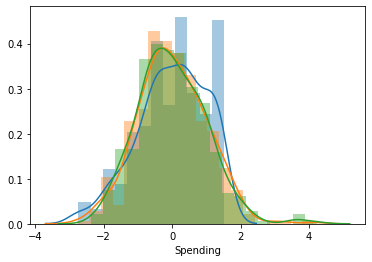

In [97]:
sns.distplot(no_UK_scaled['Recency'])
sns.distplot(no_UK_scaled['Purchase_Count'])
sns.distplot(no_UK_scaled['Spending'])
plt.show()

### UK Data

In [98]:
test_data_UK = test_data_UK.drop(['Customer_Score', 'CustomerID'], axis=1)
print(test_data_UK)

      Recency  Purchase_Count  Spending  R  F  M  RFM_Score
0         325               1  77183.60  1  1  3          5
1           2             103   4196.01  3  3  3          9
2           0            4412  33053.19  3  3  3          9
3           3             199   4090.88  3  3  3          9
4           3              59    942.34  3  2  2          7
...       ...             ...       ... .. .. ..        ...
3915      277              10    180.60  1  1  1          3
3916      180               7     80.82  1  1  1          3
3917        7              12    178.05  3  1  1          5
3918        3             721   2045.53  3  3  3          9
3919       42              70   1837.28  2  2  3          7

[3920 rows x 7 columns]


In [99]:
test_data_UK += 1

In [100]:
test_data_UK_log = np.log(test_data_UK)
print(test_data_UK_log)

       Recency  Purchase_Count   Spending         R         F         M  \
0     5.786897        0.693147  11.253955  0.693147  0.693147  1.386294   
1     1.098612        4.644391   8.342128  1.386294  1.386294  1.386294   
2     0.000000        8.392310  10.405904  1.386294  1.386294  1.386294   
3     1.386294        5.298317   8.316760  1.386294  1.386294  1.386294   
4     1.386294        4.094345   6.849427  1.386294  1.098612  1.098612   
...        ...             ...        ...       ...       ...       ...   
3915  5.627621        2.397895   5.201806  0.693147  0.693147  0.693147   
3916  5.198497        2.079442   4.404522  0.693147  0.693147  0.693147   
3917  2.079442        2.564949   5.187665  1.386294  0.693147  0.693147   
3918  1.386294        6.582025   7.623901  1.386294  1.386294  1.386294   
3919  3.761200        4.262680   7.516586  1.098612  1.098612  1.386294   

      RFM_Score  
0      1.791759  
1      2.302585  
2      2.302585  
3      2.302585  
4      2.

In [101]:
scaler.fit(test_data_UK_log)
UK_scaled = scaler.transform(test_data_UK_log)
UK_scaled = pd.DataFrame(data=UK_scaled, index=test_data_UK_log.index, columns=test_data_UK_log.columns)
print(UK_scaled)

       Recency  Purchase_Count  Spending         R         F         M  \
0     1.438428       -2.407557  3.788077 -1.289440 -1.271354  1.149744   
1    -1.953555        0.743030  1.447841  1.133300  1.153900  1.149744   
2    -2.748403        3.731493  3.106498  1.133300  1.153900  1.149744   
3    -1.745416        1.264449  1.427453  1.133300  1.153900  1.149744   
4    -1.745416        0.304442  0.248157  1.133300  0.147329  0.138098   
...        ...             ...       ...       ...       ...       ...   
3915  1.323192       -1.048249 -1.076036 -1.289440 -1.271354 -1.287737   
3916  1.012720       -1.302173 -1.716813 -1.289440 -1.271354 -1.287737   
3917 -1.243923       -0.915045 -1.087401  1.133300 -1.271354 -1.287737   
3918 -1.745416        2.288034  0.870602  1.133300  1.153900  1.149744   
3919 -0.027167        0.438667  0.784352  0.127772  0.147329  1.149744   

      RFM_Score  
0     -0.356833  
1      1.309442  
2      1.309442  
3      1.309442  
4      0.581565  
...

In [102]:
sns.distplot(UK_scaled['Recency'])
sns.distplot(UK_scaled['Purchase_Count'])
sns.distplot(UK_scaled['Spending'])
plt.show()

## KMeans Modeling

#### Elbow Method

Text(0, 0.5, 'Sum of Squares')

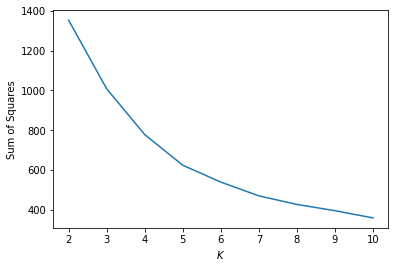

In [103]:
ss = []
assignments = {}

X_no_Uk = no_UK_scaled.to_numpy()

Krange = list(range(2, 11))

for K in Krange:
    model = sklearn.cluster.KMeans(n_clusters= K)
    assigned_cluster = model.fit_predict(X_no_Uk)
    centers = model.cluster_centers_
    ss.append(np.sum((X_no_Uk - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster

plt.plot(Krange, ss)
plt.xlabel('$K$')
plt.ylabel('Sum of Squares')

5


([<matplotlib.axis.XTick at 0x2265d20d208>,
 <a list of 5 Text xticklabel objects>)

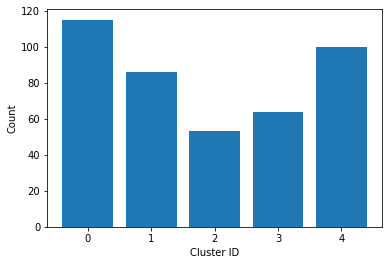

In [104]:
best_k = 5
assignments_best_k = assignments[str(best_k)]
counts = np.bincount(assignments_best_k)
print(len(counts))

plt.bar(range(best_k), counts, align='center')

plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(range(best_k))

Text(0, 0.5, 'Sum of Squares')

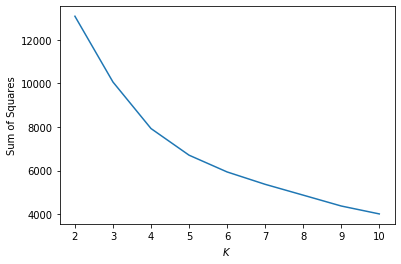

In [105]:
ss = []
assignments = {}

X_UK = UK_scaled.to_numpy()

Krange = list(range(2, 11))

for K in Krange:
    model = sklearn.cluster.KMeans(n_clusters= K)
    assigned_cluster = model.fit_predict(X_UK)
    centers = model.cluster_centers_
    ss.append(np.sum((X_UK - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster

plt.plot(Krange, ss)
plt.xlabel('$K$')
plt.ylabel('Sum of Squares')

In [106]:
best_k = 4
assignments_best_k = assignments[str(best_k)]
counts = np.bincount(assignments_best_k)
print(len(counts))

plt.bar(range(best_k), counts, align='center')

plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(range(best_k))

4


([<matplotlib.axis.XTick at 0x2265d2c35c8>,
 <a list of 4 Text xticklabel objects>)

#### Silhouette Method

For n_clusters = 2 Average Silhouette Score is: 0.44623305180544287
For n_clusters = 3 Average Silhouette Score is: 0.364153851848989
For n_clusters = 4 Average Silhouette Score is: 0.39104166464973844
For n_clusters = 5 Average Silhouette Score is: 0.4039240188946428
For n_clusters = 6 Average Silhouette Score is: 0.40086936887943675
For n_clusters = 7 Average Silhouette Score is: 0.4091405599696165
For n_clusters = 8 Average Silhouette Score is: 0.3965015619811185
For n_clusters = 9 Average Silhouette Score is: 0.3592663099425867
For n_clusters = 10 Average Silhouette Score is: 0.4117544560231758


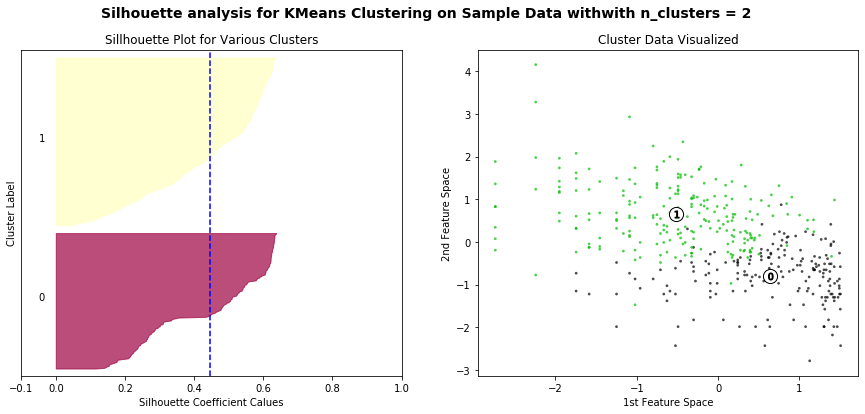

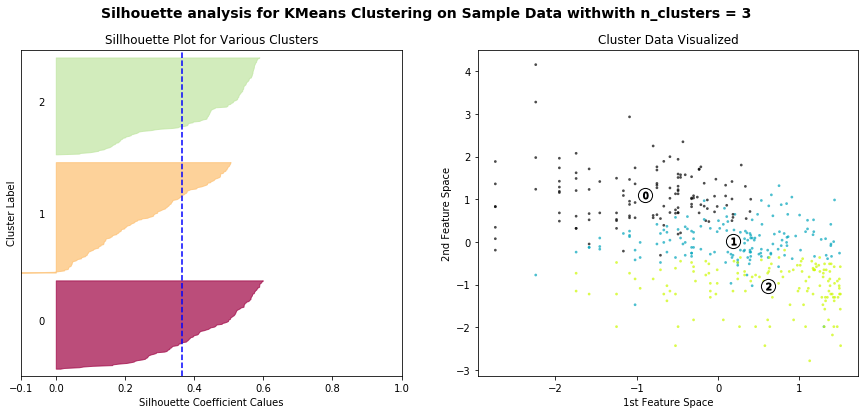

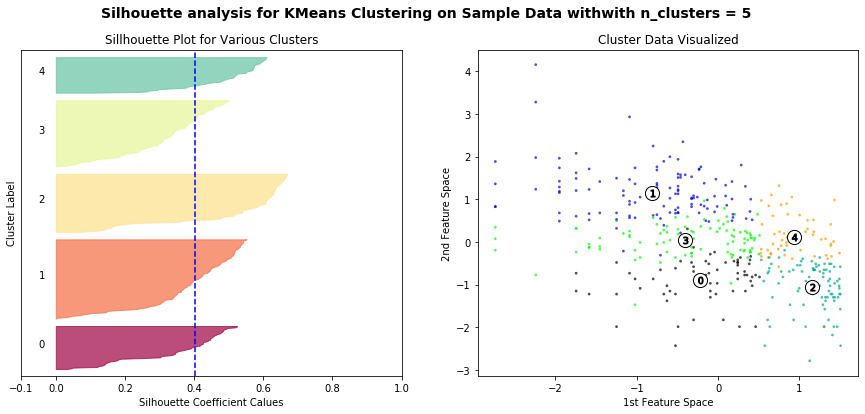

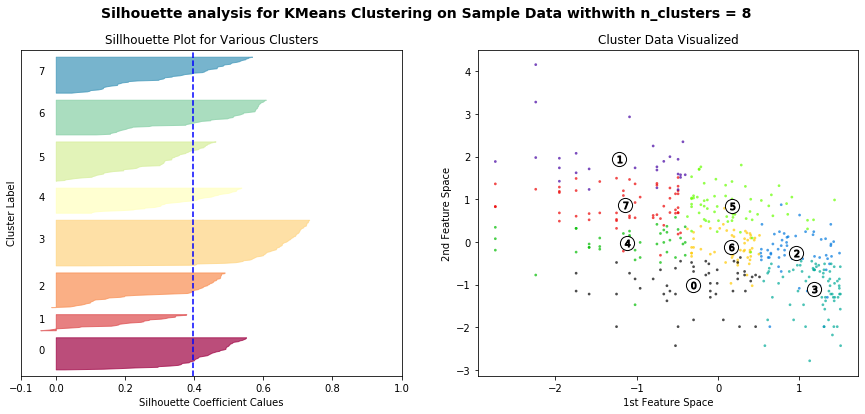

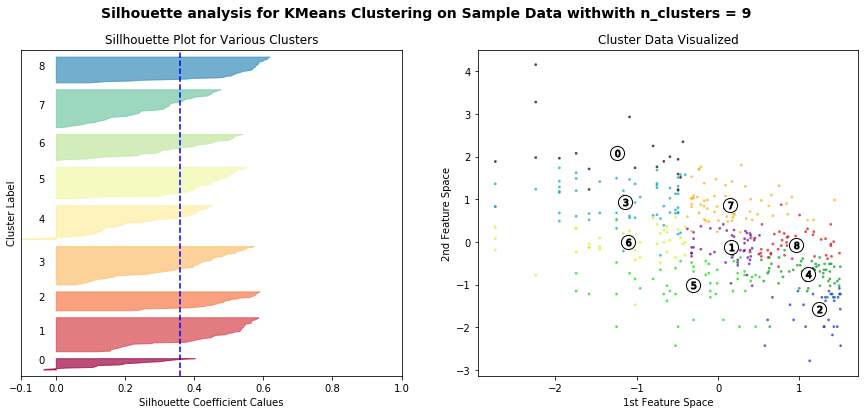

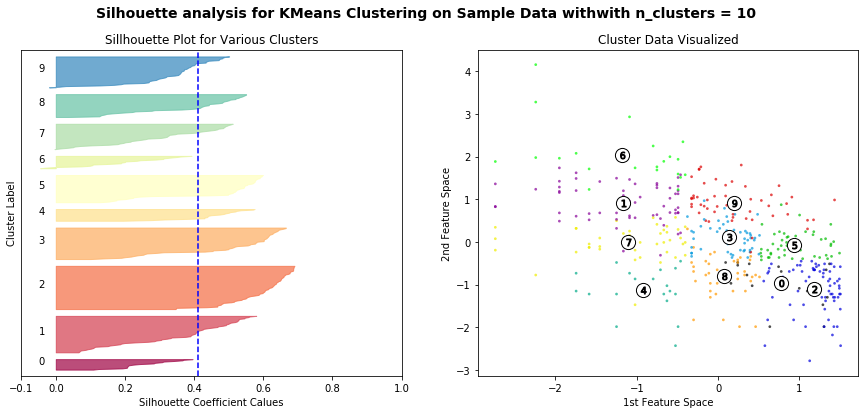

In [107]:
Krange = list(range(2, 11))
avg_silhouette_scores = []

for n_clusters in Krange: 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_no_Uk) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_no_Uk)
    
    avg_silhouette = silhouette_score(X_no_Uk, cluster_labels)
    avg_silhouette_scores.append(avg_silhouette)
    print("For n_clusters =", n_clusters, "Average Silhouette Score is:", avg_silhouette)
    
    sample_silhouette_values = silhouette_samples(X_no_Uk, cluster_labels)
    
    y_lower = 10
    
    for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap("Spectral")
            color = cmap(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, 
                              ith_cluster_silhouette_values, facecolor=color, 
                              edgecolor = color, alpha=0.7) 
            
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            
            y_lower = y_upper + 10
            
    ax1.set_title("Sillhouette Plot for Various Clusters")
    ax1.set_xlabel("Silhouette Coefficient Calues")
    ax1.set_ylabel('Cluster Label')
        
    ax1.axvline(x=avg_silhouette, color='blue', linestyle='--')\
    
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_no_Uk[:, 0], X_no_Uk[:, 1], marker = '.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    ax2.set_title('Cluster Data Visualized')
    ax2.set_xlabel('1st Feature Space')
    ax2.set_ylabel('2nd Feature Space')
    
    plt.suptitle(("Silhouette analysis for KMeans Clustering on Sample Data with"  "with n_clusters = %d" % n_clusters), 
                 fontsize=14, fontweight='bold')
                 
plt.show()               
                 

Text(0, 0.5, 'Avg Silhouette Scores')

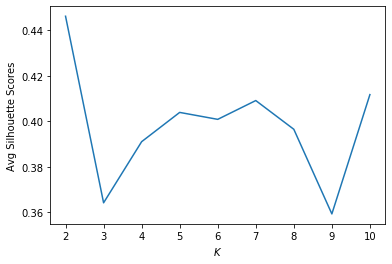

In [108]:
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Avg Silhouette Scores")

In [109]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(no_UK_scaled)
cluster_labels = kmeans.labels_

In [110]:
X_no_Uk_labels = test_data_no_UK.assign(Cluster=cluster_labels)
cluster_groups = X_no_Uk_labels.groupby(['Cluster'])

cluster_groups.agg({'Recency': 'mean', 
                    'Purchase_Count': 'mean',
                    'Spending': ['mean','count']})

Recency Purchase_Count      Spending      
               mean           mean          mean count
Cluster                                               
0        164.444444      18.277778   1481.250556    18
1         12.083333     157.216667   3942.370833    60
2        254.619718      16.070423    308.985352    71
3         58.403846      59.673077   1190.512885    52
4         14.550000      15.400000    337.363000    20
5        184.088889      48.066667   1100.715778    45
6         13.047619     780.428571  42606.348095    21
7         12.904762      52.547619   1158.742381    42
8         54.184211      22.342105    345.215789    38
9         76.333333     156.568627   4759.896078    51

For n_clusters = 2 Average Silhouette Score is: 0.43348648645091
For n_clusters = 3 Average Silhouette Score is: 0.33375530098585127
For n_clusters = 4 Average Silhouette Score is: 0.3598889872485998
For n_clusters = 5 Average Silhouette Score is: 0.34926824983060273
For n_clusters = 6 Average Silhouette Score is: 0.34524504280559093
For n_clusters = 7 Average Silhouette Score is: 0.34437549765149406
For n_clusters = 8 Average Silhouette Score is: 0.3813216403266673
For n_clusters = 9 Average Silhouette Score is: 0.3720780722991645
For n_clusters = 10 Average Silhouette Score is: 0.3990596573679666


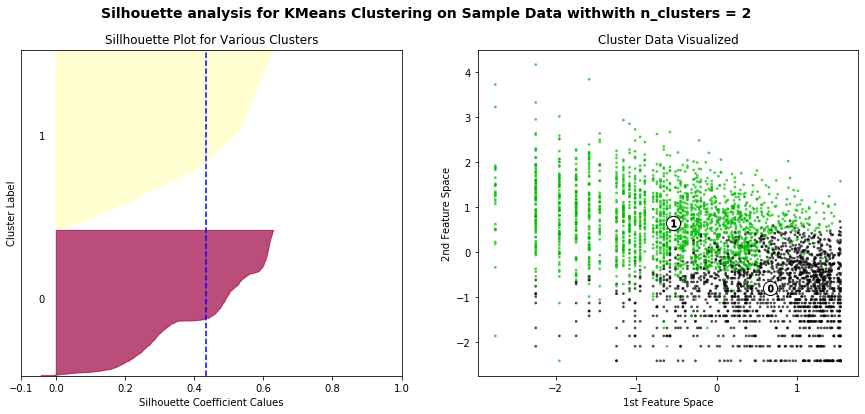

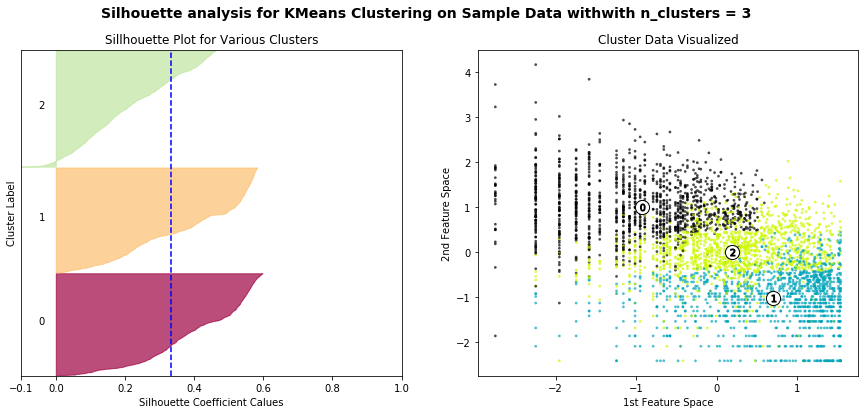

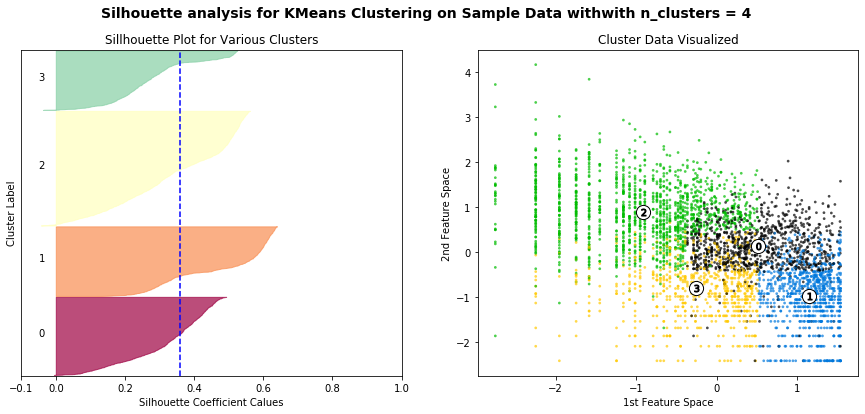

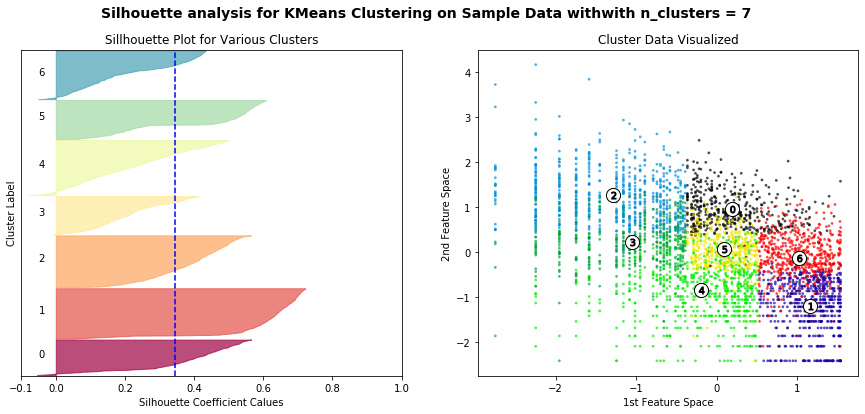

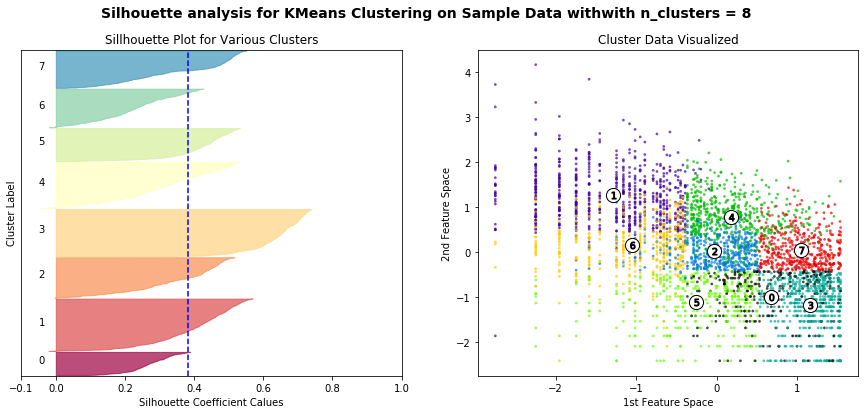

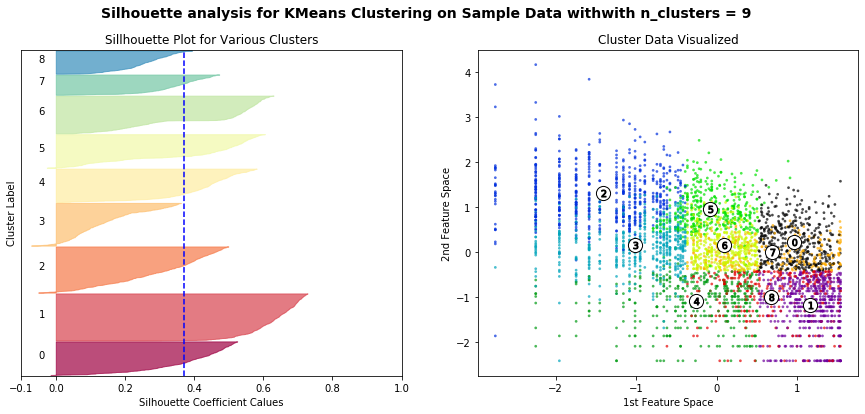

In [111]:
Krange = list(range(2, 11))
avg_silhouette_scores = []

for n_clusters in Krange: 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_UK) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_UK)
    
    avg_silhouette = silhouette_score(X_UK, cluster_labels)
    avg_silhouette_scores.append(avg_silhouette)
    print("For n_clusters =", n_clusters, "Average Silhouette Score is:", avg_silhouette)
    
    sample_silhouette_values = silhouette_samples(X_UK, cluster_labels)
    
    y_lower = 10
    
    for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap("Spectral")
            color = cmap(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, 
                              ith_cluster_silhouette_values, facecolor=color, 
                              edgecolor = color, alpha=0.7) 
            
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            
            y_lower = y_upper + 10
            
    ax1.set_title("Sillhouette Plot for Various Clusters")
    ax1.set_xlabel("Silhouette Coefficient Calues")
    ax1.set_ylabel('Cluster Label')
        
    ax1.axvline(x=avg_silhouette, color='blue', linestyle='--')\
    
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_UK[:, 0], X_UK[:, 1], marker = '.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    ax2.set_title('Cluster Data Visualized')
    ax2.set_xlabel('1st Feature Space')
    ax2.set_ylabel('2nd Feature Space')
    
    plt.suptitle(("Silhouette analysis for KMeans Clustering on Sample Data with"  "with n_clusters = %d" % n_clusters), 
                 fontsize=14, fontweight='bold')
                 
plt.show()                

In [112]:
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Avg Silhouette Scores")

Text(0, 0.5, 'Avg Silhouette Scores')

In [113]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(UK_scaled)
cluster_labels = kmeans.labels_

In [114]:
X_UK_labels = test_data_UK.assign(Cluster=cluster_labels)
cluster_groups = X_UK_labels.groupby(['Cluster'])

cluster_groups.agg({'Recency': 'mean', 
                    'Purchase_Count': 'mean',
                    'Spending': ['mean','count']})

Recency Purchase_Count     Spending      
               mean           mean         mean count
Cluster                                              
0        186.037791      54.026163   817.517762   344
1        235.154905      11.495697   197.064991   581
2         68.917706     159.351621  2913.725414   401
3         53.126609      57.218884   833.301678   466
4         40.615196      12.120098   220.247230   408
5         10.280811     288.205928  6711.154836   641
6         13.568966      61.295259  1009.993190   464
7         36.363636      47.545455   245.560856   187
8        234.440559      43.328671   240.774615   143
9        142.989474      14.322807  1388.781372   285

## Predictive Modeling

### No United Kingdom Data

#### Train_Test Split

In [115]:
X_no_UK = no_UK_scaled
X_no_UK.head()

Recency  Purchase_Count  Spending         R         F         M  RFM_Score
0 -1.952231        1.156908  1.024049  1.134171  1.162873  1.152032   1.287639
1  0.364111       -0.364846  0.351393  0.127431  0.152599  0.141051   0.152587
2 -0.629395        0.366756  0.334223  1.134171  0.152599  0.141051   0.577526
3  1.373932       -0.866960 -0.940466 -1.291490 -1.271302 -1.283847  -1.628286
4 -0.151754        0.497906  0.607031  0.127431  1.162873  1.152032   0.952349

In [116]:
y_no_UK = X_no_Uk_labels['Cluster']
y_no_UK.head()

0    1
1    3
2    7
3    2
4    9
Name: Cluster, dtype: int32

In [117]:
x_train , x_test , y_train , y_test = train_test_split(X_no_UK, y_no_UK, test_size = 0.2, random_state = 42)

#### KNN

In [118]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
print('Train Score:', knn.score(x_train, y_train))
print('Test Score:', knn.score(x_test, y_test))

Train Score: 0.9880239520958084
Test Score: 0.9523809523809523


In [119]:
y_pred_knn = knn.predict(x_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix_knn)


[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  1  0]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  1]
 [ 0  1  0  0  0  0  4  0  0  0]
 [ 1  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


In [120]:
cv_scores_train_knn = cross_val_score(knn, x_train, y_train, cv=3)
cv_scores_test_knn = cross_val_score(knn, x_test, y_test, cv=3)
print(cv_scores_test_knn)

avg_cv_scores_knn_train = cv_scores_train_knn.mean()
avg_cv_scores_knn_test = cv_scores_test_knn.mean()
cv_scores_std_knn = cv_scores_test_knn.std()
classification_report_knn = classification_report(y_test, y_pred_knn)

print('Avg cross validation train score: ', avg_cv_scores_knn_train)
print('Avg cross validation test score: ', avg_cv_scores_knn_test)
print('Standard deviation in cv scores: ', cv_scores_std_knn)
print('Classification Report:' '\n', classification_report_knn)

[0.89285714 0.75       0.85714286]
Avg cross validation train score:  0.9790057915057915
Avg cross validation test score:  0.8333333333333334
Standard deviation in cv scores:  0.060702613257056975
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        18
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         3
           5       1.00      0.92      0.96        13
           6       1.00      0.80      0.89         5
           7       1.00      0.67      0.80         3
           8       0.88      1.00      0.93         7
           9       0.91      1.00      0.95        10

    accuracy                           0.95        84
   macro avg       0.96      0.92      0.93        84
weighted avg       0.96      0.95      0.95        84



#### Decision Tree

In [121]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print('Train Score:', dt.score(x_train, y_train))
print('Test Score:', dt.score(x_test, y_test))

Train Score: 1.0
Test Score: 0.9642857142857143


In [122]:
y_pred_dt = dt.predict(x_test)

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(conf_matrix_dt)

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 1  0  0  1  0 11  0  0  0  0]
 [ 0  1  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


In [123]:
cv_scores_train_dt = cross_val_score(dt, x_train, y_train, cv=3)
cv_scores_test_dt = cross_val_score(dt, x_test, y_test, cv=3)
print(cv_scores_test_dt)

avg_cv_scores_dt_train = cv_scores_train_dt.mean()
avg_cv_scores_dt_test = cv_scores_test_dt.mean()
cv_scores_std_dt = cv_scores_test_dt.std()
classification_report_dt = classification_report(y_test, y_pred_dt)

print('Avg cross validation train score: ', avg_cv_scores_dt_train)
print('Avg cross validation test score: ', avg_cv_scores_dt_test)
print('Standard deviation in cv scores: ', cv_scores_std_dt)
print('Classification Report:' '\n', classification_report_dt)

[0.85714286 0.75       0.85714286]
Avg cross validation train score:  0.9401008151008151
Avg cross validation test score:  0.8214285714285715
Standard deviation in cv scores:  0.05050762722761052
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        18
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00         3
           5       1.00      0.85      0.92        13
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00        10

    accuracy                           0.96        84
   macro avg       0.96      0.96      0.96        84
weighted avg       0.97      0.96      0.96        84



In [127]:
dt_reg = DecisionTreeClassifier()
paramters = {"max_features": [3, 4, 5], "max_depth":[2,4,6,8,10]}
dt_cv = GridSearchCV(dt_reg, paramters, cv=5)
dt_cv.fit(x_train, y_train)
dt_cv.best_params_

{'max_depth': 6, 'max_features': 3}

In [128]:
dt_reg = DecisionTreeClassifier(max_features=3, max_depth=10)
dt_reg.fit(x_train, y_train)
print("train score:", dt_reg.score(x_train, y_train))
print("test score:", dt_reg.score(x_test, y_test))
print("average validation score:", (cross_validate(dt_reg, x_train, y_train, cv=5)["test_score"]).mean())

train score: 1.0
test score: 0.9404761904761905
average validation score: 0.9520126639529624


#### Random Forest

In [129]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print('Train Score:', rf.score(x_train, y_train))
print('Test Score:', rf.score(x_test, y_test))

Train Score: 1.0
Test Score: 0.9642857142857143


In [130]:
y_pred_rf = rf.predict(x_test)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  1  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  1  0 12  0  0  0  0]
 [ 0  1  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


In [131]:
cv_scores_train_rf = cross_val_score(rf, x_train, y_train, cv=3)
cv_scores_test_rf = cross_val_score(rf, x_test, y_test, cv=3)
print(cv_scores_test_rf)

avg_cv_scores_rf_train = cv_scores_train_rf.mean()
avg_cv_scores_rf_test = cv_scores_test_rf.mean()
cv_scores_std_rf = cv_scores_test_rf.std()
classification_report_rf = classification_report(y_test, y_pred_rf)

print('Avg cross validation train score: ', avg_cv_scores_rf_train)
print('Avg cross validation test score: ', avg_cv_scores_rf_test)
print('Standard deviation in cv scores: ', cv_scores_std_rf)
print('Classification Report:' '\n', classification_report_rf)

[0.96428571 0.96428571 0.89285714]
Avg cross validation train score:  0.9581456456456457
Avg cross validation test score:  0.9404761904761906
Standard deviation in cv scores:  0.033671751485073675
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.93      0.93      0.93        14
           2       1.00      1.00      1.00        18
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00         3
           5       1.00      0.92      0.96        13
           6       1.00      0.80      0.89         5
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00        10

    accuracy                           0.96        84
   macro avg       0.95      0.97      0.96        84
weighted avg       0.97      0.96      0.96        84



#### Naive Bayes

In [132]:
nb = GaussianNB()
nb.fit(x_train, y_train)
print('Train Score:', nb.score(x_train, y_train))
print('Test Score:', nb.score(x_test, y_test))

Train Score: 0.8592814371257484
Test Score: 0.8214285714285714


In [133]:
y_pred_nb = nb.predict(x_test)

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print(conf_matrix_nb)

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0 11  1  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  1  1]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


In [134]:
cv_scores_train_nb = cross_val_score(nb, x_train, y_train, cv=3)
cv_scores_test_nb = cross_val_score(nb, x_test, y_test, cv=3)
print(cv_scores_test_nb)

avg_cv_scores_nb_train = cv_scores_train_nb.mean()
avg_cv_scores_nb_test = cv_scores_test_nb.mean()
cv_scores_std_nb = cv_scores_test_nb.std()
classification_report_nb = classification_report(y_test, y_pred_nb)

print('Avg cross validation train score:', avg_cv_scores_nb_train)
print('Avg cross validation test score:', avg_cv_scores_nb_test)
print('Standard deviation in cv scores:', cv_scores_std_nb)
print('Classification Report:' '\n', classification_report_nb)

[0.78571429 0.89285714 0.75      ]
Avg cross validation train score: 0.8413502788502788
Avg cross validation test score: 0.8095238095238096
Standard deviation in cv scores: 0.06070261325705699
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.14      0.25        14
           2       1.00      1.00      1.00        18
           3       1.00      0.67      0.80         6
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00        13
           6       0.31      1.00      0.48         5
           7       0.67      0.67      0.67         3
           8       0.88      1.00      0.93         7
           9       0.91      1.00      0.95        10

    accuracy                           0.82        84
   macro avg       0.85      0.85      0.79        84
weighted avg       0.92      0.82      0.80        84



#### Gradient Boosting

In [135]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
print('Train Score:', gb.score(x_train, y_train))
print('Test Score:', gb.score(x_test, y_test))

Train Score: 1.0
Test Score: 0.9642857142857143


In [136]:
y_pred_gb = gb.predict(x_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print(conf_matrix_gb)

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  1  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0]
 [ 0  1  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  1  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


In [137]:
cv_scores_train_gb = cross_val_score(gb, x_train, y_train, cv=3)
cv_scores_test_gb = cross_val_score(gb, x_test, y_test, cv=3)
print(cv_scores_test_gb)

avg_cv_scores_gb_train = cv_scores_train_gb.mean()
avg_cv_scores_gb_test = cv_scores_test_gb.mean()
cv_scores_std_gb = cv_scores_test_gb.std()
classification_report_gb = classification_report(y_test, y_pred_gb)

print('Avg cross validation train score: ', avg_cv_scores_gb_train)
print('Avg cross validation test score: ', avg_cv_scores_gb_test)
print('Standard deviation in cv scores: ', cv_scores_std_gb)
print('Classification Report:' '\n', classification_report_gb)

[0.75       0.85714286 0.71428571]
Avg cross validation train score:  0.9341484341484342
Avg cross validation test score:  0.7738095238095238
Standard deviation in cv scores:  0.060702613257056934
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.93      0.93      0.93        14
           2       1.00      1.00      1.00        18
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00        13
           6       1.00      0.80      0.89         5
           7       0.75      1.00      0.86         3
           8       1.00      0.86      0.92         7
           9       1.00      1.00      1.00        10

    accuracy                           0.96        84
   macro avg       0.95      0.96      0.95        84
weighted avg       0.97      0.96      0.96        84



In [138]:
gb = GradientBoostingClassifier()
paramters = {"n_estimators": [100, 200, 300], "max_depth":[2,4,6,8,10]}
gb_cv = GridSearchCV(gb, paramters, cv=3)
gb_cv.fit(x_train, y_train)
gb_cv.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [139]:
gb = GradientBoostingClassifier(n_estimators=200, max_depth=2)
gb.fit(x_train, y_train)
print("train score:", gb.score(x_train, y_train))
print("test score:", gb.score(x_test, y_test))
print("average validation score:", (cross_validate(gb, x_train, y_train, cv=5)["test_score"]).mean())

train score: 1.0
test score: 0.9761904761904762
average validation score: 0.9429669832654908


## UK Data

In [140]:
X_UK = UK_scaled
X_UK.head()

Recency  Purchase_Count  Spending        R         F         M  RFM_Score
0  1.438428       -2.407557  3.788077 -1.28944 -1.271354  1.149744  -0.356833
1 -1.953555        0.743030  1.447841  1.13330  1.153900  1.149744   1.309442
2 -2.748403        3.731493  3.106498  1.13330  1.153900  1.149744   1.309442
3 -1.745416        1.264449  1.427453  1.13330  1.153900  1.149744   1.309442
4 -1.745416        0.304442  0.248157  1.13330  0.147329  0.138098   0.581565

In [141]:
y_UK = X_UK_labels['Cluster']
y_UK.head()

0    9
1    5
2    5
3    5
4    6
Name: Cluster, dtype: int32

In [142]:
x_train , x_test , y_train , y_test = train_test_split(X_UK, y_UK, test_size = 0.2, random_state = 42)

#### KNN

In [143]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
print('Train Score:', knn.score(x_train, y_train))
print('Test Score:', knn.score(x_test, y_test))

Train Score: 0.9952168367346939
Test Score: 0.9936224489795918


In [144]:
y_pred_knn = knn.predict(x_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix_knn)

[[ 68   0   1   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  0   0  75   1   0   0   0   0   0   0]
 [  0   0   0  91   0   0   0   0   0   0]
 [  0   0   0   0  81   0   0   0   0   0]
 [  0   0   0   0   0 125   3   0   0   0]
 [  0   0   0   0   0   0  93   0   0   0]
 [  0   0   0   0   0   0   0  42   0   0]
 [  0   0   0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0   0   0   0  58]]


In [145]:
cv_scores_train_knn = cross_val_score(knn, x_train, y_train, cv=3)
cv_scores_test_knn = cross_val_score(knn, x_test, y_test, cv=3)
print(cv_scores_test_knn)

avg_cv_scores_knn_train = cv_scores_train_knn.mean()
avg_cv_scores_knn_test = cv_scores_test_knn.mean()
cv_scores_std_knn = cv_scores_test_knn.std()
classification_report_knn = classification_report(y_test, y_pred_knn)

print('Avg cross validation train score: ', avg_cv_scores_knn_train)
print('Avg cross validation test score: ', avg_cv_scores_knn_test)
print('Standard deviation in cv scores: ', cv_scores_std_knn)
print('Classification Report:' '\n', classification_report_knn)

[0.98091603 0.97701149 1.        ]
Avg cross validation train score:  0.9885216256354427
Avg cross validation test score:  0.9859758415957417
Standard deviation in cv scores:  0.01004387425595464
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        69
           1       1.00      1.00      1.00       122
           2       0.99      0.99      0.99        76
           3       0.99      1.00      0.99        91
           4       1.00      1.00      1.00        81
           5       1.00      0.98      0.99       128
           6       0.97      1.00      0.98        93
           7       1.00      1.00      1.00        42
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        58

    accuracy                           0.99       784
   macro avg       0.99      0.99      0.99       784
weighted avg       0.99      0.99      0.99       784



#### Decision Tree

In [146]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print('Train Score:', dt.score(x_train, y_train))
print('Test Score:', dt.score(x_test, y_test))

Train Score: 1.0
Test Score: 0.9885204081632653


In [147]:
y_pred_dt = dt.predict(x_test)

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(conf_matrix_dt)

[[ 69   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  2   0  73   1   0   0   0   0   0   0]
 [  0   0   0  91   0   0   0   0   0   0]
 [  0   0   0   0  80   0   1   0   0   0]
 [  0   0   0   0   0 126   2   0   0   0]
 [  0   0   0   0   2   1  90   0   0   0]
 [  0   0   0   0   0   0   0  42   0   0]
 [  0   0   0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0   0   0   0  58]]


In [148]:
cv_scores_train_dt = cross_val_score(dt, x_train, y_train, cv=3)
cv_scores_test_dt = cross_val_score(dt, x_test, y_test, cv=3)
print(cv_scores_test_dt)

avg_cv_scores_dt_train = cv_scores_train_dt.mean()
avg_cv_scores_dt_test = cv_scores_test_dt.mean()
cv_scores_std_dt = cv_scores_test_dt.std()
classification_report_dt = classification_report(y_test, y_pred_dt)

print('Avg cross validation train score: ', avg_cv_scores_dt_train)
print('Avg cross validation test score: ', avg_cv_scores_dt_test)
print('Standard deviation in cv scores: ', cv_scores_std_dt)
print('Classification Report:' '\n', classification_report_dt)

[0.98473282 0.98467433 0.96934866]
Avg cross validation train score:  0.9894794782889781
Avg cross validation test score:  0.9795852709777426
Standard deviation in cv scores:  0.007238417135552816
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        69
           1       1.00      1.00      1.00       122
           2       1.00      0.96      0.98        76
           3       0.99      1.00      0.99        91
           4       0.98      0.99      0.98        81
           5       0.99      0.98      0.99       128
           6       0.97      0.97      0.97        93
           7       1.00      1.00      1.00        42
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        58

    accuracy                           0.99       784
   macro avg       0.99      0.99      0.99       784
weighted avg       0.99      0.99      0.99       784



#### Random Forest

In [149]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print('Train Score:', rf.score(x_train, y_train))
print('Test Score:', rf.score(x_test, y_test))

Train Score: 1.0
Test Score: 0.9923469387755102


In [150]:
y_pred_rf = rf.predict(x_test)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

[[ 69   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  0   0  75   1   0   0   0   0   0   0]
 [  0   0   0  91   0   0   0   0   0   0]
 [  0   0   0   0  81   0   0   0   0   0]
 [  0   0   0   0   0 125   3   0   0   0]
 [  0   0   0   0   0   2  91   0   0   0]
 [  0   0   0   0   0   0   0  42   0   0]
 [  0   0   0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0   0   0   0  58]]


In [151]:
cv_scores_train_rf = cross_val_score(rf, x_train, y_train, cv=3)
cv_scores_test_rf = cross_val_score(rf, x_test, y_test, cv=3)
print(cv_scores_test_rf)

avg_cv_scores_rf_train = cv_scores_train_rf.mean()
avg_cv_scores_rf_test = cv_scores_test_rf.mean()
cv_scores_std_rf = cv_scores_test_rf.std()
classification_report_rf = classification_report(y_test, y_pred_rf)

print('Avg cross validation train score: ', avg_cv_scores_rf_train)
print('Avg cross validation test score: ', avg_cv_scores_rf_test)
print('Standard deviation in cv scores: ', cv_scores_std_rf)
print('Classification Report:' '\n', classification_report_rf)

[0.99236641 0.98084291 0.98850575]
Avg cross validation train score:  0.9891592792166405
Avg cross validation test score:  0.9872383570725239
Standard deviation in cv scores:  0.004789048142168317
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00       122
           2       1.00      0.99      0.99        76
           3       0.99      1.00      0.99        91
           4       1.00      1.00      1.00        81
           5       0.98      0.98      0.98       128
           6       0.97      0.98      0.97        93
           7       1.00      1.00      1.00        42
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        58

    accuracy                           0.99       784
   macro avg       0.99      0.99      0.99       784
weighted avg       0.99      0.99      0.99       784



In [152]:
rf = RandomForestClassifier()
paramters = {"n_estimators": [100, 200, 300], "max_depth":[2,4,6,8,10]}
rf_cv = GridSearchCV(rf, paramters, cv=5)
rf_cv.fit(x_train, y_train)
rf_cv.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [153]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10)
rf.fit(x_train, y_train)
print("train score:", rf.score(x_train, y_train))
print("test score:", rf.score(x_test, y_test))
print("average validation score:", (cross_validate(rf, x_train, y_train, cv=5)["test_score"]).mean())

train score: 1.0
test score: 0.9936224489795918
average validation score: 0.9923475451802638


#### Naive Bayes

In [154]:
nb = GaussianNB()
nb.fit(x_train, y_train)
print('Train Score:', nb.score(x_train, y_train))
print('Test Score:', nb.score(x_test, y_test))

Train Score: 0.9802295918367347
Test Score: 0.9732142857142857


In [155]:
y_pred_nb = nb.predict(x_test)

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print(conf_matrix_nb)

[[ 69   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  6   0  63   7   0   0   0   0   0   0]
 [  0   0   0  91   0   0   0   0   0   0]
 [  0   0   0   0  78   0   1   0   0   2]
 [  0   0   0   0   0 124   4   0   0   0]
 [  0   0   0   0   0   0  93   0   0   0]
 [  0   0   0   0   0   0   1  41   0   0]
 [  0   0   0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0   0   0   0  58]]


In [156]:
cv_scores_train_nb = cross_val_score(nb, x_train, y_train, cv=3)
cv_scores_test_nb = cross_val_score(nb, x_test, y_test, cv=3)
print(cv_scores_test_nb)

avg_cv_scores_nb_train = cv_scores_train_nb.mean()
avg_cv_scores_nb_test = cv_scores_test_nb.mean()
cv_scores_std_nb = cv_scores_test_nb.std()
classification_report_nb = classification_report(y_test, y_pred_nb)

print('Avg cross validation train score:', avg_cv_scores_nb_train)
print('Avg cross validation test score:', avg_cv_scores_nb_test)
print('Standard deviation in cv scores:', cv_scores_std_nb)
print('Classification Report:' '\n', classification_report_nb)

[0.98473282 0.97701149 0.98467433]
Avg cross validation train score: 0.9789556021114842
Avg cross validation test score: 0.98213954939409
Standard deviation in cv scores: 0.0036261611990824577
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        69
           1       1.00      1.00      1.00       122
           2       1.00      0.83      0.91        76
           3       0.93      1.00      0.96        91
           4       1.00      0.96      0.98        81
           5       1.00      0.97      0.98       128
           6       0.94      1.00      0.97        93
           7       1.00      0.98      0.99        42
           8       1.00      1.00      1.00        24
           9       0.97      1.00      0.98        58

    accuracy                           0.97       784
   macro avg       0.98      0.97      0.97       784
weighted avg       0.98      0.97      0.97       784



#### Gradient Boosting

In [157]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
print('Train Score:', gb.score(x_train, y_train))
print('Test Score:', gb.score(x_test, y_test))

Train Score: 1.0
Test Score: 0.9948979591836735


In [158]:
y_pred_gb = gb.predict(x_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print(conf_matrix_gb)

[[ 69   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  0   0  75   1   0   0   0   0   0   0]
 [  0   0   0  91   0   0   0   0   0   0]
 [  0   0   0   0  81   0   0   0   0   0]
 [  0   0   0   0   0 125   3   0   0   0]
 [  0   0   0   0   0   0  93   0   0   0]
 [  0   0   0   0   0   0   0  42   0   0]
 [  0   0   0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0   0   0   0  58]]


In [159]:
cv_scores_train_gb = cross_val_score(gb, x_train, y_train, cv=3)
cv_scores_test_gb = cross_val_score(gb, x_test, y_test, cv=3)
print(cv_scores_test_gb)

avg_cv_scores_gb_train = cv_scores_train_gb.mean()
avg_cv_scores_gb_test = cv_scores_test_gb.mean()
cv_scores_std_gb = cv_scores_test_gb.std()
classification_report_gb = classification_report(y_test, y_pred_gb)

print('Avg cross validation train score: ', avg_cv_scores_gb_train)
print('Avg cross validation test score: ', avg_cv_scores_gb_test)
print('Standard deviation in cv scores: ', cv_scores_std_gb)
print('Classification Report:' '\n', classification_report_gb)

[0.96946565 0.97318008 0.98084291]
Avg cross validation train score:  0.9869267293037044
Avg cross validation test score:  0.9744962124535697
Standard deviation in cv scores:  0.004737065800909475
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00       122
           2       1.00      0.99      0.99        76
           3       0.99      1.00      0.99        91
           4       1.00      1.00      1.00        81
           5       1.00      0.98      0.99       128
           6       0.97      1.00      0.98        93
           7       1.00      1.00      1.00        42
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        58

    accuracy                           0.99       784
   macro avg       1.00      1.00      1.00       784
weighted avg       1.00      0.99      0.99       784



In [160]:
gb = GradientBoostingClassifier()
paramters = {"n_estimators": [100, 200, 300], "max_depth":[2,4,6,8,10]}
gb_cv = GridSearchCV(gb, paramters, cv=3)
gb_cv.fit(x_train, y_train)
gb_cv.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [161]:
gb = GradientBoostingClassifier(n_estimators=200, max_depth=2)
gb.fit(x_train, y_train)
print("train score:", gb.score(x_train, y_train))
print("test score:", gb.score(x_test, y_test))
print("average validation score:", (cross_validate(gb, x_train, y_train, cv=5)["test_score"]).mean())

train score: 1.0
test score: 0.9936224489795918
average validation score: 0.9913906073812206
